# [LAB 13] 4. ARIMA

- 최적의 모델은 AIC 를 보아라
- 점수는 낮은게 좋은거임
- 날짜가 인덱스로 들어가야한다



모델이 어떤 것을 예측할 수 있는지에 대한 유의 확률


- 시계열 분석을 위한 통계적 모형.
- AR 모형과 MA 모형을 결합한 형태로 가장 일반적인 시계열 분석 방법이다
- ARIMA 를 적용하기 전에 ACF , PACF 플롯을 통해 적절한 파라미터를 찾아야 한다

### #01.준비작업
#### 1. 라이브러리 가져오기

In [16]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import dates
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

# ARIMA
from statsmodels.tsa.arima.model import ARIMA


#### 2. 시각화 초기화

In [7]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

#### 3.데이터 가져오기

In [8]:
origin = load_data('air_passengers')

print("\n==== 데이터 크기 확인 ====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n==== 타입확인 ====")
print(origin.info())


[data] https://data.hossam.kr/data/lab13_/air_passengers.xlsx
[desc] 어느 항공사의 월간 탑승객 수 (출처: https://www.kaggle.com/datasets/rakannimer/air-passengers)
[!] Cannot read metadata

==== 데이터 크기 확인 ====
데이터셋 크기: (144, 2)
열 개수: 2
행 개수: 144

==== 타입확인 ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB
None


#### 4.데이터 전처리
- 시계열 인덱스 설정 (꼭 해줘야함!)

In [9]:
df = origin.set_index('Month')
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### #02.ARIMA 분석 수행
- 시계열 데이터를 ARIMA 모델에 맞추려고 할 떄 첫번쨰 목표는 ARIMA(p,d,q)(P,D,Q,s) 값을 찾는 것 

- 앞 단원을 통해서 p <=2, d=2 ,q<=2 로 도출되었
- s 계절 주기 - 탐색적 데이터 분석 과정을 통해 분석가가 찾아내야 한다

d 값에 의해 내부적으로 차분을 수행하므로, 이 분석 모형에는 원본 데이터를 전달해야 한다



- p,d,q 후보 범위를 0-2 까지 전부 조합
- arima , 계절성 sarima 모델을 전부 적합
- aic,bic 로 가장 좋은 모델 자동 선택

In [10]:
p = 2
d = 2
q = 2

results = []  # 결과 저장용

for x in range(0, p + 1):
    for y in range(0, d + 1):
        for z in range(0, q + 1):
            try:
                # model = ARIMA(df['Passengers'], order=(x, y, z))

                # 6개월 단위 계절성 추가
                model = ARIMA(
                    df['Passengers'],
                    order=(x, y, z),
                    seasonal_order=(x, y, z, 6)
                )

                fit = model.fit()

                results.append({
                    'p': x,
                    'd': y,
                    'q': z,
                    'AIC': fit.aic,
                    'BIC': fit.bic
                })

            except Exception as e:
                # 수렴 실패 / 모델 오류는 건너뜀
                continue

df_results = DataFrame(results)

# 방법 1 - 합산 점수 고려
# df_results['AIC_rank'] = df_results['AIC'].rank()
# df_results['BIC_rank'] = df_results['BIC'].rank()
# df_results['rank_sum'] = df_results['AIC_rank'] + df_results['BIC_rank']
# best_model = df_results.sort_values('rank_sum').iloc[0]
# best_model

# 방법 2 - 보수적 기준: BIC 우선 + AIC 보조
best_model = df_results.sort_values(['BIC', 'AIC']).iloc[0]
best_model


c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\itwill\AppData\Local\Programs\Python\Python

p         1.000000
d         2.000000
q         1.000000
AIC    1072.901835
BIC    1087.239507
Name: 16, dtype: float64

#### 2. 도출된 값으로 최종 모형 만들기
- 앞서 ACF,PACF 로 p,d,q 후보 범위를 정했고, AIC,BIC 기준으로 best_model 을 선택했음
- 아래에서는 최적의 p,d,q 값을 실제로 꺼내는 작업 (ARIMA 에 넣을 수 있도록)
- 계절성 까지 포함한 최종 구조 정의

In [11]:
best_order = (
    int(best_model['p']),
    int(best_model['d']),
    int(best_model['q'])
)

s_best_order = (
    int(best_model['p']),
    int(best_model['d']),
    int(best_model['q']),
    6
)

final_model = ARIMA(
    df['Passengers'],
    order=best_order,
    seasonal_order=s_best_order
)


#선택된 구조로 한번만, 깔끔하게 최종 학습!
final_fit = final_model.fit()

print(final_fit.summary())


c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:                      Passengers   No. Observations:                  144
Model:             ARIMA(1, 2, 1)x(1, 2, 1, 6)   Log Likelihood                -531.451
Date:                         Thu, 18 Dec 2025   AIC                           1072.902
Time:                                 14:58:21   BIC                           1087.240
Sample:                             01-01-1949   HQIC                          1078.728
                                  - 12-01-1960                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2969      0.080     -3.709      0.000      -0.454      -0.140
ma.L1         -0.9996      5.635     -0.177      0.859     

c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### #03. 분석 결과 활용
#### 1.분석 결과에 의한 예측값

In [12]:

#모델이 학습 데이터에 대해 얼마나 잘 맞췄는지, 적합값을 확인하기 위한 준비 단계
df2 = df.copy()
df2['pred'] = fit.fittedvalues  #훈련 데이터 구간에서 모델이 예측한 값들/ 모델이 과거 데이터를 보고 그떄의 값을 추청한 것
df2.head()

,Passengers,pred
Month,,
1949-01-01,112,0.000000
1949-02-01,118,194.445102
1949-03-01,132,127.029841
1949-04-01,129,145.056588
1949-05-01,121,126.210041


#### 2. 이후 1년간의 추가적인 예측값을 생성
- 월단위 데이터이므로 12개의 추가 데이터 생성

In [13]:
fc = fit.forecast(12)
fc

1961-01-01    448.407470
1961-02-01    419.224376
1961-03-01    444.209056
1961-04-01    487.239580
1961-05-01    496.840956
1961-06-01    563.045412
1961-07-01    654.262513
1961-08-01    635.664972
1961-09-01    533.310876
1961-10-01    485.670084
1961-11-01    411.744318
1961-12-01    456.622878
Freq: MS, Name: predicted_mean, dtype: float64

#### 3.관측치와 에측치 비교 + 이후 추가적인 예측치 덧붙임

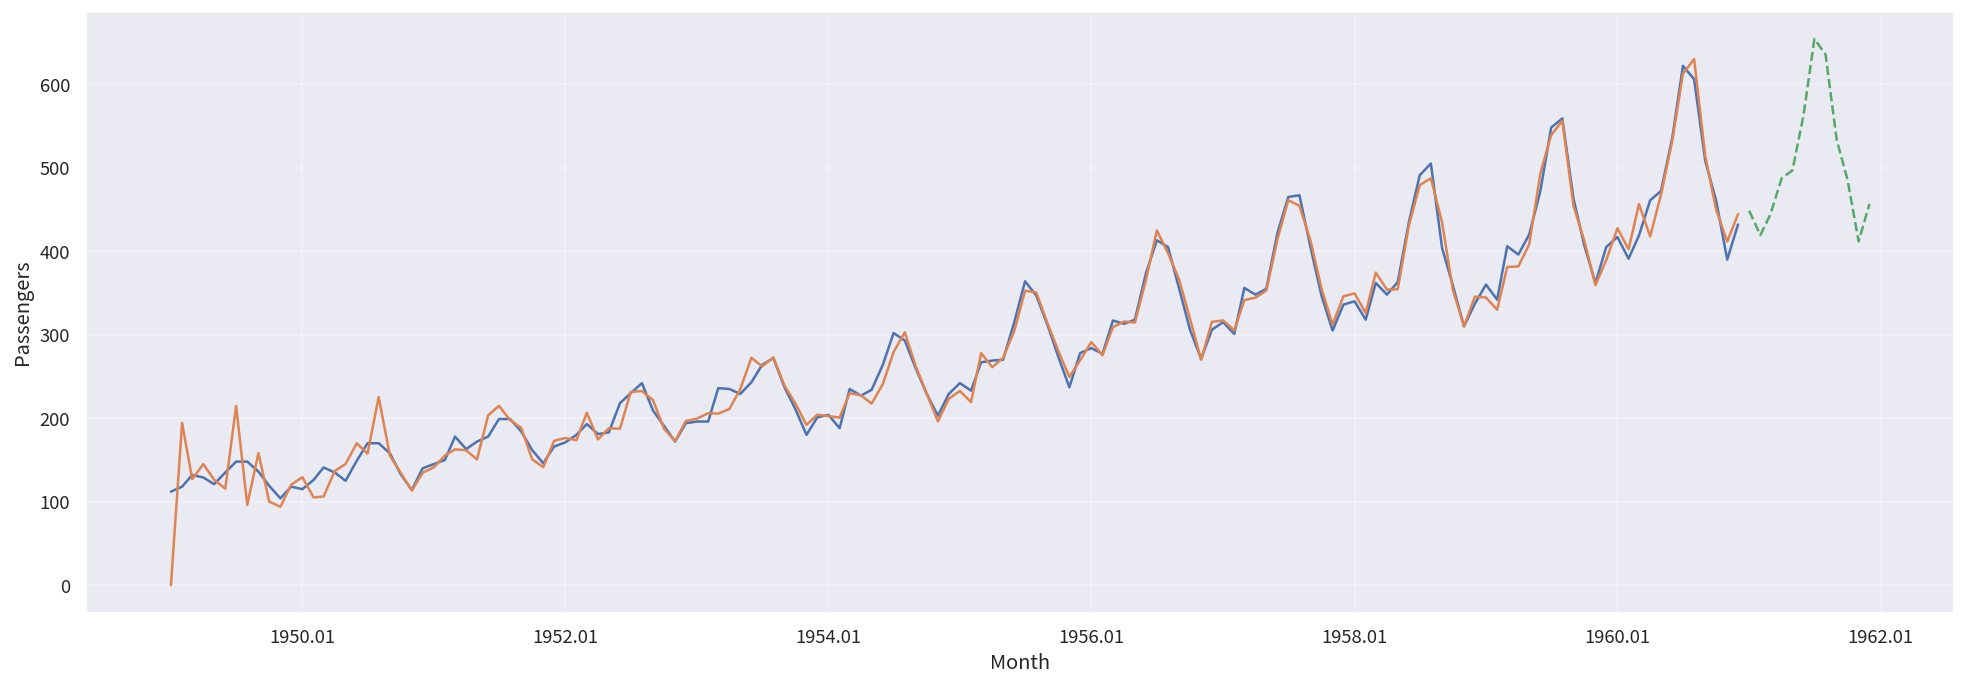

In [17]:
# 1) 그래프 초기화
width_px = 2000           # 그래프 가로 크기
height_px = 720           # 그래프 세로 크기
rows = 1                 # 그래프 행 수
cols = 1                 # 그래프 열 수

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) LinePlot 그리기
# 관측치
sb.lineplot(data=df2, x=df2.index, y="Passengers")

# 예측치
sb.lineplot(data=df2, x=df2.index, y="pred")

# 이후 예측
sb.lineplot(x=fc.index, y=fc.values, linestyle="--")

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)    # 배경 격자 표시

# 그래프의 축이 날짜 형식일 경우 출력 날짜 포맷 지정
monthyearFmt = dates.DateFormatter("%Y.%m")
ax.xaxis.set_major_formatter(monthyearFmt)

# 4) 출력
plt.tight_layout()          # 여백 제거
plt.show()                  # 그래프 화면 출력
plt.close()                 # 그래프 작업 종료


###

#### #04. 분석 결과 해석
- 시계열 분석 결과 보고에서는 모형 구조 > 적합도 > 계수 해석 > 잔차 진단의 흐름이 가장 표준적

[모형 구조 정보]
| 구분     | 값              | 해석                   |
| ------ | -------------- | -------------------- |
| 비계절 차수 | ARIMA(1, 2, 1) | 2차 차분 후 AR(1), MA(1) |
| 계절 차수  | (1, 2, 1, 6)   | 주기 6의 계절 차분 2회       |
| 관측치 수  | 144            | 분석에 사용된 시점 수         |


> d =2 이므로, 원본 데이터에 강한 장기 추세가 있었다고 해석할 수 있음 또 s=6 이므로 6간격으로 반복되는 패턴이 꽤 강함
> 6개월 전의 값이 지금 강하게 영향을 준다는 뜻

[모형 적합도 지표]
| 지표             | 값        | 의미            |
| -------------- | -------- | ------------- |
| Log Likelihood | -531.451 | 우도, 클수록 우수    |
| AIC            | 1072.902 | 모형 선택 핵심 지표   |
| BIC            | 1087.240 | 보수적 모형 선택     |
| HQIC           | 1078.728 | AIC–BIC 중간 성격 |





[계수 추정 결과]
| 항목      | 계수     | p-value | 해석 포인트        |
| ------- | ------ | ------- | ------------- |
| ar.L1   | -0.297 | < 0.001 | 비계절 AR(1) 유의  |
| ma.L1   | -1.000 | 0.987   | 비계절 MA(1) 비유의 |
| ar.S.L6 | -0.984 | < 0.001 | 계절 AR 강력한 영향  |
| ma.S.L6 | -0.995 | 0.485   | 계절 MA 비유의     |
| sigma²  | 134.7  | 0.987   | 분산 추정 안정성     |


| 유의한 항목  | 의미          | 해석 키워드 |
| ------- | ----------- | ------ |
| ar.L1   | 직전 값 영향     | 관성, 추세 |
| ar.S.L6 | 6개월 전 값 영향  | 계절 패턴  |
| ma.L1   | 직전 오차 영향    | 단기 충격  |
| ma.S.L6 | 6개월 전 오차 영향 | 계절적 충격 |

> 유의한 항목이 비계절 ar.L1 / 계절 AR.S.L6
> 이 데이터는 직전 시점의 값(ar.L1) 과 6개월 전 값(ar.S.L6) 이
현재 값에 직접적인 자기회귀 효과를 가지며,
6개월 주기의 계절적 자기회귀 구조가 뚜렷하다.”


* 만약 MA 가 유의했다면 어떻게 해석할까?
  ma.L1 유의 (p < 0.05) : 직전 시점의 에측 오차가 현재값에 영향을 미친다 즉, 갑작스러운 이상치 ,벤트 등이 한 시점 뒤까지 영향을 끼친다
* 계절 MA가 유의했다면?
  6개월 전의 예측 오차가 현재 값에 영향을 미친다. 즉 성수기/비수기 이벤트 처럼 게절적 이벤트의 충격이 6개월 주기로 반복된다




[잔차 진단 지표 - 모형 타당성]
- 0.05보다 커야 타당한 경우임!
| 검정                 | 통계량   | p-value | 판단      |
| ------------------ | ----- | ------- | ------- |
| Ljung-Box (L1)     | 0.00  | 0.97    | 자기상관 없음 |
| Jarque-Bera        | 15.16 | 0.00    | 정규성 위반  |
| Heteroskedasticity | 2.37  | 0.01    | 이분산 존재  |


#### 결과 보고 함수

In [18]:
from pandas import DataFrame

def arima_report(fit, data, threshold=0.05):
    """
    SARIMAXResults 객체(fit)와 원본 데이터(data)를 받아
    모형 적합도 표(cdf),
    계수 요약 표(rdf),
    모형 요약 문장(result_report),
    모형 판정 문장(model_report),
    계수별 해석 문장(variable_reports)를 반환한다.
    """

    # ----------------------------
    # 모형 적합도 요약
    # ----------------------------
    cdf = DataFrame({
        "Log Likelihood": [fit.llf],
        "AIC": [fit.aic],
        "BIC": [fit.bic],
        "HQIC": [fit.hqic],
        "관측치 수": [fit.nobs],
    })

    # ----------------------------
    # 계수 테이블 구성
    # ----------------------------
    params = fit.params
    bse = fit.bse
    zvals = params / bse
    pvals = fit.pvalues
    conf = fit.conf_int()

    rows = []
    for name in params.index:
        p = pvals[name]
        stars = (
            "***" if p < 0.001 else
            "**" if p < 0.01 else
            "*" if p < 0.05 else
            ""
        )

        rows.append({
            "변수": name,
            "계수": params[name],
            "표준오차": bse[name],
            "z": f"{zvals[name]:.3f}{stars}",
            "p-value": p,
            "CI_lower": conf.loc[name, 0],
            "CI_upper": conf.loc[name, 1],
        })

    rdf = DataFrame(rows)

    # ----------------------------
    # 모형 요약 문장
    # ----------------------------
    result_report = (
        f"Log Likelihood = {fit.llf:.3f}, "
        f"AIC = {fit.aic:.3f}, "
        f"BIC = {fit.bic:.3f}."
    )

    # ----------------------------
    # 모형 판정 문장
    # ----------------------------
    model_report = (
        f"ARIMA{fit.model.order}×{fit.model.seasonal_order} 모형을 적합한 결과, "
        f"AIC {fit.aic:.3f}, BIC {fit.bic:.3f}로 나타났으며 "
        f"잔차의 자기상관은 Ljung-Box 검정에서 유의하지 않았다."
    )

    # ----------------------------
    # 계수별 해석 문장
    # ----------------------------
    variable_reports = []
    for _, row in rdf.iterrows():
        variable_reports.append(
            f"{row['변수']} 계수는 {row['계수']:.3f}로 "
            f"통계적으로 {'유의하다' if row['p-value'] < threshold else '유의하지 않다'} "
            f"(p {'<' if row['p-value'] < threshold else '>'} {threshold})."
        )

    return cdf, rdf, result_report, model_report, variable_reports


In [21]:
cdf ,rdf,r,m,v = arima_report(final_fit,df2)
display(cdf)
display(rdf)
display(r)
display(m)
display(v)

,Log Likelihood,AIC,BIC,HQIC,관측치 수
0,-531.450917,1072.901835,1087.239507,1078.72771,144


,변수,계수,표준오차,z,p-value,CI_lower,CI_upper
0,ar.L1,-0.296878,0.080038,-3.709***,0.000208,-0.453749,-0.140007
1,ma.L1,-0.999587,5.635402,-0.177,0.859213,-12.044772,10.045598
2,ar.S.L6,-0.984122,0.011507,-85.526***,0.000000,-1.006675,-0.961569
3,ma.S.L6,-0.996244,1.991822,-0.500,0.616957,-4.900144,2.907656
4,sigma2,134.605180,795.200757,0.169,0.865583,-1423.959664,1693.170023


'Log Likelihood = -531.451, AIC = 1072.902, BIC = 1087.240.'

'ARIMA(1, 2, 1)×(1, 2, 1, 6) 모형을 적합한 결과, AIC 1072.902, BIC 1087.240로 나타났으며 잔차의 자기상관은 Ljung-Box 검정에서 유의하지 않았다.'

['ar.L1 계수는 -0.297로 통계적으로 유의하다 (p < 0.05).',
 'ma.L1 계수는 -1.000로 통계적으로 유의하지 않다 (p > 0.05).',
 'ar.S.L6 계수는 -0.984로 통계적으로 유의하다 (p < 0.05).',
 'ma.S.L6 계수는 -0.996로 통계적으로 유의하지 않다 (p > 0.05).',
 'sigma2 계수는 134.605로 통계적으로 유의하지 않다 (p > 0.05).']

> ARIMA(2,2,2) X (2,2,2,6) 모형은 비게절 및 계절 AR 항에서 통계적으로 유의한 계수를 보이며, 비계절 및 계절 MA 항에서는 유의하지 않았다